## CSC 215 - Project 2
### Khoi Hoang
### William Dobson

In [1]:
import os
import csv
import json
import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib.pyplot import figure, show
import matplotlib.pyplot as plt
import collections

In [2]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()    
    
# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)


### Convert JSON data into tabular format for Pandas

In [2]:
#reviews.json
outfile = open("review_stars.tsv", 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','stars', 'text'])
with open('review.json', encoding="utf8") as f:
    for line in f:
        row = json.loads(line)
        # some special char must be encoded in 'utf-8'
        sfile.writerow([row['business_id'], row['stars'], (row['text']).encode('utf-8')])

outfile.close()

In [3]:
#business.json
outfile = open("business.tsv", 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','stars', 'review_count', 'categories'])
with open('business.json', encoding="utf8") as f:
    for line in f:
        row = json.loads(line)
        # some special char must be encoded in 'utf-8'
        sfile.writerow([row['business_id'], row['stars'], row['review_count'], row['categories']])

outfile.close()

In [4]:
#tip.json
outfile = open("tip.tsv", 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','text'])
with open('tip.json', encoding="utf8") as f:
    for line in f:
        row = json.loads(line)
        # some special char must be encoded in 'utf-8'
        sfile.writerow([row['business_id'], (row['text']).encode('utf-8')])

outfile.close()

In [3]:
df_review= pd.read_csv('review_stars.tsv', delimiter ="\t", encoding="utf-8")
df_business= pd.read_csv('business.tsv', delimiter ="\t", encoding="utf-8")
df_tip= pd.read_csv('tip.tsv', delimiter ="\t", encoding="utf-8")
df_tip[0:5]

,business_id,text
0,VaKXUpmWTTWDKbpJ3aQdMw,"b'Great for watching games, ufc, and whatever ..."
1,OPiPeoJiv92rENwbq76orA,b'Happy Hour 2-4 daily with 1/2 price drinks a...
2,5KheTjYPu1HcQzQFtm4_vw,b'Good chips and salsa. Loud at times. Good se...
3,TkoyGi8J7YFjA6SbaRzrxg,b'The setting and decoration here is amazing. ...
4,AkL6Ous6A1atZejfZXn1Bg,b'Molly is definately taking a picture with Sa...


In [4]:
df_review.head()

,business_id,stars,text
0,ujmEBvifdJM6h6RLv4wQIg,1.0,b'Total bill for this horrible service? Over $...
1,NZnhc2sEQy3RmzKTZnqtwQ,5.0,"b""I *adore* Travis at the Hard Rock's new Kell..."
2,WTqjgwHlXbSFevF32_DJVw,5.0,"b""I have to say that this office really has it..."
3,ikCg8xy5JIg_NGPx-MSIDA,5.0,"b""Went in for a lunch. Steak sandwich was deli..."
4,b1b1eb3uo-w561D0ZfCEiQ,1.0,b'Today was my second out of three sessions I ...


In [5]:
df_review = df_review[df_review['text'].str.len() >= 50]
df_review.shape

(6678404, 3)

In [6]:
df_tip = df_tip[df_tip['text'].str.len() >= 20]
df_tip.shape

(1094522, 2)

In [7]:
#group all reviews by each business and create a new dataframe, where each line is a business with all its reviews
df_review_agg = df_review.groupby('business_id')['text'].sum()

df_all_reviews = pd.DataFrame({'business_id': df_review_agg.index, 'all_reviews': df_review_agg.values})

In [8]:
#group all tip by each business and create a new dataframe, where each line is a business with all its tips
df_tip_agg = df_tip.groupby('business_id')['text'].sum()

df_all_tips = pd.DataFrame({'business_id': df_tip_agg.index, 'all_tips': df_tip_agg.values})

In [10]:
df_all_tips.head()

,business_id,all_tips
0,--1UhMGODdWsrMastO9DZw,"b""Delicious! One of the best burritos, salsa a..."
1,--6MefnULPED_I942VcFNA,b'BBQ pork is sold out early on Saturday'b'$5 ...
2,--7zmmkVg-IMGaXbuVd0SQ,"b""Good place to stop when traffic don't go.""b'..."
3,--9QQLMTbFzLJ_oT-ON3Xw,"b""Tip? Don't get your hair cut here. If they'r..."
4,--9e1ONYQuAa-CB_Rrw7Tw,b'Wine pairings for my prix fixe meal. Mmmm'b...


#### Only consider businesses which have more than 20 reviews

In [9]:
df_business = df_business[df_business['review_count'] >= 20]
df_business.shape

(57644, 4)

In [10]:
#merge df_business, df_all_reviews, and df_all_tips by business_id
df_ready_for_sklearn = pd.merge(pd.merge(df_all_reviews, df_business, on='business_id', how='inner'), df_all_tips, on='business_id', how='inner')
df_ready_for_sklearn.shape

(54657, 6)

In [11]:
df_ready_for_sklearn['review_count_zscore'] = zscore(df_ready_for_sklearn['review_count'])
df_ready_for_sklearn[0:5]

,business_id,all_reviews,stars,review_count,categories,all_tips,review_count_zscore
0,--1UhMGODdWsrMastO9DZw,b'If you are looking for authentic Mexican str...,4.0,24,"Restaurants, Mexican","b""Delicious! One of the best burritos, salsa a...",-0.390434
1,--6MefnULPED_I942VcFNA,"b""They have the best Chinese BBQ Pork (Char Si...",3.0,44,"Chinese, Restaurants",b'BBQ pork is sold out early on Saturday'b'The...,-0.286046
2,--7zmmkVg-IMGaXbuVd0SQ,"b""I'm a tad reluctant to write a review as I r...",4.0,58,"Breweries, Food","b""Good place to stop when traffic don't go.""b'...",-0.212974
3,--9e1ONYQuAa-CB_Rrw7Tw,b'Very busy and noisy restaurant.\nAsparagas w...,4.0,1613,"Cajun/Creole, Seafood, Steakhouses, Restaurants",b'Wine pairings for my prix fixe meal. Mmmm'b...,7.903234
4,--DaPTJW3-tB1vP-PfdTEg,b'My sister and in laws were in town and we wa...,3.5,49,"Restaurants, Breakfast & Brunch",b'Awesome. Huge portions definitely worth a v...,-0.259948


In [14]:
#label encode the stars
le = preprocessing.LabelEncoder()
df_ready_for_sklearn['encoded_stars'] = le.fit_transform(df_ready_for_sklearn['stars'])

In [33]:
print(df_ready_for_sklearn.shape)
df_ready_for_sklearn[0:5]

(54947, 5)


,all_reviews,stars,review_count,all_tips,review_count_zscore
0,b'If you are looking for authentic Mexican str...,4.0,-0.389458,"b""Delicious! One of the best burritos, salsa a...",-0.389461
1,"b""They have the best Chinese BBQ Pork (Char Si...",3.0,-0.284830,b'BBQ pork is sold out early on Saturday'b'$5 ...,-0.284833
2,"b""I'm a tad reluctant to write a review as I r...",4.0,-0.211590,"b""Good place to stop when traffic don't go.""b'...",-0.211592
3,b'Very busy and noisy restaurant.\nAsparagas w...,4.0,7.923231,b'Wine pairings for my prix fixe meal. Mmmm'b...,7.923303
4,b'My sister and in laws were in town and we wa...,3.5,-0.258673,b'Awesome. Huge portions definitely worth a v...,-0.258675


### Use tfidfVectorizer to obtain TFIDF representation for each business

In [13]:
import sklearn.feature_extraction.text as sk_text

#obtain tfidf score for reviews
vectorizer = sk_text.TfidfVectorizer(max_features=250, min_df=10)

reviews_matrix = vectorizer.fit_transform(df_ready_for_sklearn['all_reviews'])

reviews_tfidf = reviews_matrix.toarray()

In [14]:
print(reviews_tfidf.shape)
vectorizer.get_feature_names()

(54947, 250)


['10',
 'about',
 'after',
 'again',
 'all',
 'also',
 'always',
 'am',
 'amazing',
 'an',
 'and',
 'another',
 'any',
 'are',
 'area',
 'around',
 'as',
 'asked',
 'at',
 'atmosphere',
 'away',
 'awesome',
 'back',
 'bad',
 'bar',
 'be',
 'because',
 'been',
 'before',
 'being',
 'best',
 'better',
 'big',
 'bit',
 'both',
 'burger',
 'but',
 'by',
 'came',
 'can',
 'car',
 'check',
 'cheese',
 'chicken',
 'clean',
 'coffee',
 'come',
 'could',
 'customer',
 'day',
 'definitely',
 'delicious',
 'did',
 'didn',
 'different',
 'dinner',
 'do',
 'don',
 'down',
 'drink',
 'drinks',
 'eat',
 'enough',
 'even',
 'ever',
 'every',
 'everything',
 'excellent',
 'experience',
 'favorite',
 'feel',
 'few',
 'find',
 'first',
 'food',
 'for',
 'found',
 'free',
 'fresh',
 'friendly',
 'friends',
 'fries',
 'from',
 'get',
 'give',
 'go',
 'going',
 'good',
 'got',
 'great',
 'had',
 'happy',
 'has',
 'have',
 'he',
 'her',
 'here',
 'his',
 'home',
 'hot',
 'hour',
 'how',
 'if',
 'in',
 'into'

In [15]:
#obtain tfidf score for tips
vectorizer = sk_text.TfidfVectorizer(max_features=250, min_df=10)

tips_matrix = vectorizer.fit_transform(df_ready_for_sklearn['all_tips'])

tips_tfidf = tips_matrix.toarray()

In [38]:
print(tips_tfidf[0:5])
vectorizer.get_feature_names()

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.021811   0.         0.01278567 ... 0.02276033 0.03685077 0.02221714]
 [0.         0.         0.         ... 0.         0.         0.        ]]


['10',
 '20',
 '30',
 'about',
 'after',
 'again',
 'all',
 'also',
 'always',
 'am',
 'amazing',
 'an',
 'and',
 'any',
 'are',
 'area',
 'around',
 'as',
 'ask',
 'at',
 'atmosphere',
 'awesome',
 'back',
 'bad',
 'bar',
 'be',
 'because',
 'beef',
 'been',
 'beer',
 'before',
 'best',
 'better',
 'big',
 'breakfast',
 'bring',
 'burger',
 'busy',
 'but',
 'by',
 'can',
 'check',
 'cheese',
 'chicken',
 'clean',
 'closed',
 'coffee',
 'come',
 'coming',
 'cool',
 'cream',
 'customer',
 'day',
 'definitely',
 'delicious',
 'did',
 'dinner',
 'do',
 'don',
 'down',
 'drink',
 'drinks',
 'early',
 'eat',
 'even',
 'ever',
 'every',
 'everything',
 'excellent',
 'experience',
 'family',
 'fantastic',
 'fast',
 'favorite',
 'first',
 'fish',
 'food',
 'for',
 'free',
 'fresh',
 'fried',
 'friendly',
 'fries',
 'from',
 'fun',
 'get',
 'getting',
 'go',
 'going',
 'good',
 'got',
 'great',
 'had',
 'half',
 'happy',
 'has',
 'have',
 'he',
 'here',
 'highly',
 'home',
 'hot',
 'hour',
 'ho

# Linear Regression

Preparing data for training/testing

In [39]:
#Merge reviews_tfidf, tips_tfidf and review_count into one array for input
temp = df_ready_for_sklearn['review_count_zscore'].values
input_data = np.column_stack((reviews_tfidf, tips_tfidf))
input_data = np.column_stack((input_data, temp))
input_data.shape

(54947, 501)

In [40]:
#split into train/test data
x_train, x_test, y_train, y_test = train_test_split(input_data, df_ready_for_sklearn['stars'], test_size=0.25, random_state=43)

In [23]:
test_data = input_data[test_loc[0]]
for i in range(1, len(test_loc)):
    test_data = np.append(test_data, input_data[test_loc[i]], axis=0)
test_data.shape

(5, 501)

In [24]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(41210, 501)
(13737, 501)
(41210,)
(13737,)


In [25]:
from sklearn.linear_model import LinearRegression

# instantiate the model (using the default parameters)
linreg = LinearRegression()

# fit the model with data
linreg.fit(x_train, y_train)

# predict the response for new observations
y_pred_Linear = linreg.predict(test_data)

In [26]:
print("Prediction result: ")
print("Business ID                         Categories             Predicted Star Rating         True Star Rating")
for i in range(5):
    print("{:.20}             {:.23}         {:.5}                         {}".format(test_businesses[i]['business_id'], test_businesses[i]['categories'], y_pred_Linear[i], test_true_stars[i]))

Prediction result: 
Business ID                         Categories             Predicted Star Rating         True Star Rating
--DaPTJW3-tB1vP-PfdT             Restaurants, Breakfast          3.5785                         3.5
-AZN6ojHeKPMubDFgDK8             Bike Rentals, Hotels &          3.5649                         4.0
JBoARyTQR-bRzA_Ed2Rs             Shopping, Mobile Phones         2.2591                         2.0
6oYiBbib5jHD-yzVbht0             Self Storage, Local Ser         4.5228                         5.0
4O3Qv9ieFTCMJVeKcRp6             Skin Care, Hair Removal         3.8619                         4.5


### Support Vector Machine

In [27]:
#split into train/test data
#using encoded stars because classification problem
x_train, x_test, y_train, y_test = train_test_split(input_data, df_ready_for_sklearn['encoded_stars'], test_size=0.25, random_state=43)

In [28]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(41210, 501)
(13737, 501)
(41210,)
(13737,)


In [50]:
from sklearn.svm import LinearSVC

clf = LinearSVC(dual=False)
clf.fit(x_train, y_train)

y_pred_SVM = clf.predict(test_data)

In [51]:
y_pred_SVM = le.inverse_transform(y_pred_SVM)
print("Prediction result: ")
print("Business ID                         Categories             Predicted Star Rating         True Star Rating")
for i in range(5):
    print("{:.20}             {:.23}         {:.5}                         {}".format(test_businesses[i]['business_id'], test_businesses[i]['categories'], y_pred_SVM[i], test_true_stars[i]))

Prediction result: 
Business ID                         Categories             Predicted Star Rating         True Star Rating
--DaPTJW3-tB1vP-PfdT             Restaurants, Breakfast          3.5                         3.5
-AZN6ojHeKPMubDFgDK8             Bike Rentals, Hotels &          4.0                         4.0
JBoARyTQR-bRzA_Ed2Rs             Shopping, Mobile Phones         2.0                         2.0
6oYiBbib5jHD-yzVbht0             Self Storage, Local Ser         5.0                         5.0
4O3Qv9ieFTCMJVeKcRp6             Skin Care, Hair Removal         4.0                         4.5


C:\Users\wdobs\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(x_train, y_train)

# predict the response for new observations
y_pred_Logistic = logreg.predict(test_data)

In [32]:
y_pred_Logistic = le.inverse_transform(y_pred_Logistic)
print("Prediction result: ")
print("Business ID                         Categories             Predicted Star Rating         True Star Rating")
for i in range(5):
    print("{:.20}             {:.23}         {:.5}                         {}".format(test_businesses[i]['business_id'], test_businesses[i]['categories'], y_pred_Logistic[i], test_true_stars[i]))

Prediction result: 
Business ID                         Categories             Predicted Star Rating         True Star Rating
--DaPTJW3-tB1vP-PfdT             Restaurants, Breakfast          3.5                         3.5
-AZN6ojHeKPMubDFgDK8             Bike Rentals, Hotels &          4.0                         4.0
JBoARyTQR-bRzA_Ed2Rs             Shopping, Mobile Phones         2.0                         2.0
6oYiBbib5jHD-yzVbht0             Self Storage, Local Ser         4.5                         5.0
4O3Qv9ieFTCMJVeKcRp6             Skin Care, Hair Removal         3.5                         4.5


C:\Users\wdobs\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### Nearest Neighbor

In [33]:
from sklearn.neighbors import KNeighborsClassifier

# instantiate the model (using the value K=10)
knn = KNeighborsClassifier(n_neighbors=10)

# fit the model with data
knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [34]:
# predict the response for new observations
y_neighbor = knn.predict(test_data)

In [35]:
y_neighbor = le.inverse_transform(y_neighbor)
print("Prediction result: ")
print("Business ID                         Categories             Predicted Star Rating         True Star Rating")
for i in range(5):
    print("{:.20}             {:.23}         {:.5}                         {}".format(test_businesses[i]['business_id'], test_businesses[i]['categories'], y_neighbor[i], test_true_stars[i]))

Prediction result: 
Business ID                         Categories             Predicted Star Rating         True Star Rating
--DaPTJW3-tB1vP-PfdT             Restaurants, Breakfast          4.0                         3.5
-AZN6ojHeKPMubDFgDK8             Bike Rentals, Hotels &          3.5                         4.0
JBoARyTQR-bRzA_Ed2Rs             Shopping, Mobile Phones         2.0                         2.0
6oYiBbib5jHD-yzVbht0             Self Storage, Local Ser         2.5                         5.0
4O3Qv9ieFTCMJVeKcRp6             Skin Care, Hair Removal         4.5                         4.5


C:\Users\wdobs\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### Multinomial Naive Bayes

In [36]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

temp = scaler.fit_transform(df_ready_for_sklearn['review_count'].values.reshape(1, -1))

input_data_MNB = np.column_stack((reviews_tfidf, tips_tfidf))
input_data_MNB = np.column_stack((input_data_MNB, temp.reshape(-1,1)))

input_data_MNB

C:\Users\wdobs\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


array([[0.00545978, 0.00977371, 0.01489321, ..., 0.        , 0.        ,
        0.        ],
       [0.00834362, 0.02613826, 0.01896645, ..., 0.        , 0.        ,
        0.        ],
       [0.00710458, 0.04027406, 0.01291994, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00767693, 0.01832359, 0.00930718, ..., 0.        , 0.        ,
        0.        ],
       [0.01202863, 0.0255702 , 0.01503871, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.03271716, 0.01789648, ..., 0.        , 0.        ,
        0.        ]])

In [37]:
test_data = input_data_MNB[test_loc[0]]
for i in range(1, len(test_loc)):
    test_data = np.append(test_data, input_data_MNB[test_loc[i]], axis=0)
test_data.shape

(5, 501)

In [38]:
x_train, x_test, y_train, y_test = train_test_split(input_data_MNB, df_ready_for_sklearn['encoded_stars'], test_size=0.25, random_state=43)

In [42]:
from sklearn.naive_bayes import MultinomialNB

# instantiate the model (using the default parameters)
mnb = MultinomialNB()

# fit the model with data
mnb.fit(x_train, y_train)

# predict the response for new observations
y_mnb = mnb.predict(test_data)

In [43]:
y_mnb = le.inverse_transform(y_mnb)
print("Prediction result: ")
print("Business ID                         Categories             Predicted Star Rating         True Star Rating")
for i in range(5):
    print("{:.20}             {:.23}         {:.5}                         {}".format(test_businesses[i]['business_id'], test_businesses[i]['categories'], y_mnb[i], test_true_stars[i]))

Prediction result: 
Business ID                         Categories             Predicted Star Rating         True Star Rating
--DaPTJW3-tB1vP-PfdT             Restaurants, Breakfast          4.0                         3.5
-AZN6ojHeKPMubDFgDK8             Bike Rentals, Hotels &          4.0                         4.0
JBoARyTQR-bRzA_Ed2Rs             Shopping, Mobile Phones         4.5                         2.0
6oYiBbib5jHD-yzVbht0             Self Storage, Local Ser         4.5                         5.0
4O3Qv9ieFTCMJVeKcRp6             Skin Care, Hair Removal         4.5                         4.5


C:\Users\wdobs\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# TensorFlow

In [12]:
%matplotlib inline
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import optimizers

C:\Users\wdobs\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [13]:
x_train, x_test, y_train, y_test = train_test_split(df_ready_for_sklearn, df_ready_for_sklearn['stars'], test_size=0.25, random_state=43)

In [14]:
import sklearn.feature_extraction.text as sk_text

#obtain tfidf score for reviews
vectorizer = sk_text.TfidfVectorizer(max_features=250, min_df=10)

reviews_matrix_train = vectorizer.fit_transform(x_train['all_reviews'])
reviews_tfidf_train = reviews_matrix_train.toarray()

reviews_matrix_test = vectorizer.fit_transform(x_test['all_reviews'])
reviews_tfidf_test = reviews_matrix_test.toarray()

In [17]:
#obtain tfidf score for tips
vectorizer = sk_text.TfidfVectorizer(max_features=250, min_df=10)

tips_matrix_train = vectorizer.fit_transform(x_train['all_tips'])
tips_tfidf_train = tips_matrix_train.toarray()

tips_matrix_test = vectorizer.fit_transform(x_test['all_tips'])
tips_tfidf_test = tips_matrix_test.toarray()

In [18]:
temp = x_train['review_count_zscore'].values
input_data_train = np.column_stack((reviews_tfidf_train, tips_tfidf_train))
input_data_train = np.column_stack((input_data_train, temp))
input_data_train.shape

temp = x_test['review_count_zscore'].values
input_data_test = np.column_stack((reviews_tfidf_test, tips_tfidf_test))
input_data_test = np.column_stack((input_data_test, temp))
input_data_test.shape

(13665, 501)

In [71]:
df_train = pd.DataFrame(input_data_train)
df_test = pd.DataFrame(input_data_test)
df_train['stars'] = y_train
df_test['stars'] = y_test

In [72]:
df_train.shape

(40992, 502)

In [73]:
y_train.shape

(40992,)

In [74]:
y_train.isnull().values.any()

False

In [82]:
df_train['stars'] = y_train

In [83]:
df_train.shape

(40992, 502)

In [85]:
df_train['stars'].isnull().values.any()

True

In [84]:
df_train[100:105]

,0,1,2,3,4,5,6,7,8,9,...,492,493,494,495,496,497,498,499,500,stars
100,0.008780,0.032284,0.029612,0.010545,0.058824,0.012659,0.015407,0.007432,0.003481,0.036197,...,0.084451,0.039175,0.037494,0.0,0.247442,0.186718,0.0,0.0,-0.129463,2.5
101,0.003391,0.042570,0.020603,0.009397,0.059565,0.026480,0.024007,0.015945,0.013442,0.058748,...,0.000000,0.000000,0.000000,0.0,0.000000,0.078859,0.0,0.0,-0.155560,3.5
102,0.014673,0.013159,0.013375,0.018075,0.056799,0.061706,0.013552,0.000000,0.033935,0.039452,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,-0.390434,3.0
103,0.007827,0.020056,0.009173,0.012396,0.042950,0.023176,0.005163,0.002103,0.034357,0.032069,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,-0.072049,NaN
104,0.007696,0.027607,0.028059,0.003555,0.030936,0.027740,0.007108,0.003619,0.015256,0.020692,...,0.239257,0.000000,0.212449,0.0,0.000000,0.000000,0.0,0.0,-0.317362,4.0


In [81]:
x_train,y_train = to_xy(train,'stars')

KeyError: '501'

In [28]:
# Encode to a 2D matrix for training
x,y = to_xy(df_train,'stars')

In [32]:
x.shape

(54947, 501)

In [31]:
y.shape

(54947,)

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=43)

In [43]:
model = Sequential()

model.add(Dense(501, input_dim=x_train.shape[1], activation='relu')) # Hidden 1     #  why input_dim=x.shape[1]?  
model.add(Dense(200, activation='relu')) # Hidden 2
model.add(Dense(100, activation='relu')) # Hidden 3
model.add(Dense(10, activation='relu')) # Hidden 4
model.add(Dense(1)) # Output

model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath=".\lowest_error.hdf5", verbose=0, save_best_only=True) # save best model


model.fit(x_train,y_train,callbacks=[monitor,checkpointer],verbose=2,epochs=100)    # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.


Epoch 1/100
 - 7s - loss: 0.2713
Epoch 2/100


C:\Users\wdobs\Anaconda3\lib\site-packages\keras\callbacks.py:434: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


 - 7s - loss: 0.1065
Epoch 3/100
 - 7s - loss: 0.0966
Epoch 4/100
 - 7s - loss: 0.0878
Epoch 5/100
 - 7s - loss: 0.0785
Epoch 6/100
 - 7s - loss: 0.0728
Epoch 7/100
 - 7s - loss: 0.0665
Epoch 8/100
 - 7s - loss: 0.0595
Epoch 9/100
 - 7s - loss: 0.0539
Epoch 10/100
 - 7s - loss: 0.0470
Epoch 11/100
 - 7s - loss: 0.0441
Epoch 12/100
 - 7s - loss: 0.0394
Epoch 13/100
 - 7s - loss: 0.0347
Epoch 14/100
 - 7s - loss: 0.0317
Epoch 15/100
 - 7s - loss: 0.0288
Epoch 16/100
 - 7s - loss: 0.0264
Epoch 17/100
 - 7s - loss: 0.0240
Epoch 18/100
 - 8s - loss: 0.0230
Epoch 19/100
 - 8s - loss: 0.0211
Epoch 20/100
 - 8s - loss: 0.0203
Epoch 21/100
 - 8s - loss: 0.0187
Epoch 22/100
 - 8s - loss: 0.0180
Epoch 23/100
 - 8s - loss: 0.0163
Epoch 24/100
 - 8s - loss: 0.0161
Epoch 25/100
 - 8s - loss: 0.0151
Epoch 26/100
 - 8s - loss: 0.0142
Epoch 27/100
 - 8s - loss: 0.0139
Epoch 28/100
 - 8s - loss: 0.0130
Epoch 29/100
 - 8s - loss: 0.0126
Epoch 30/100
 - 8s - loss: 0.0118
Epoch 31/100
 - 8s - loss: 0.0114


In [44]:
pred = model.predict(x_test)
print("Shape: {}".format(pred.shape))
print(pred)

Shape: (13737, 1)
[[3.4908915]
 [4.138049 ]
 [4.5802135]
 ...
 [3.9663963]
 [4.1042547]
 [4.3584704]]


In [45]:
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 0.34771791100502014


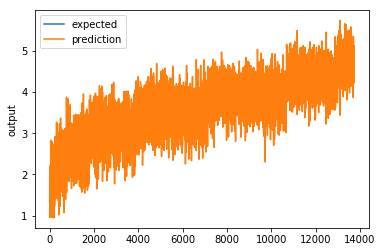

In [47]:
# Plot the chart
chart_regression(pred.flatten(),y_test)